# Dog breed classification using Pytorch

- Transfer learning using Resnet-50

In [455]:
# import the tools we need
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from pytorch_lightning import metrics
from sklearn.preprocessing impbort LabelEncoder
from sklearn.model_selection import train_test_splitb

In [530]:
# Read the csv files
comp_df = pd.read_csv('../input/dog-breed-identification/labels.csv')
test_df = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')

# How many number of images in Training set and test set?
print('Training set: {}, Test set: {}'.format(comp_df.shape[0],test_df.shape[0]))

Training set: 10222, Test set: 10357


# Prepare dataframe for training set

- Prepare dataframe with two columns: complete file path and labels (transferd to index)
- Create a index-2-breed dictionary

In [458]:
# how may dog breed in training set? 
comp_df.breed.value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

In [531]:
# Encode the breed into digits
comp_df['label'] = LabelEncoder().fit_transform(comp_df.breed)

# Create a breed-2-index dictionary
dict_df = comp_df[['label','breed']].copy()
dict_df.drop_duplicates(inplace=True)
dict_df.set_index('label',drop=True,inplace=True)
index_to_breed = dict_df.to_dict()['breed']

In [532]:
# Change the id to full file path
train_dir = '../input/dog-breed-identification/train'
comp_df.id = comp_df.id.apply(lambda x: x+'.jpg')
comp_df.id = comp_df.id.apply(lambda x:train_dir+'/'+x)

# Drop the breed column
comp_df.pop('breed')

0                     boston_bull
1                           dingo
2                        pekinese
3                        bluetick
4                golden_retriever
                   ...           
10217                      borzoi
10218              dandie_dinmont
10219                    airedale
10220          miniature_pinscher
10221    chesapeake_bay_retriever
Name: breed, Length: 10222, dtype: object

# Have a look on the images

In [461]:
def show_images(df,img_num):
    sample = df.sample(img_num)
    paths = sample.id.tolist()
    for path in paths:
        plt.figure(figsize=(3,3))
        img = plt.imread(path)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

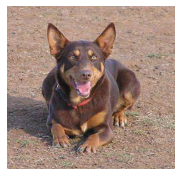

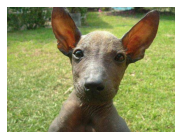

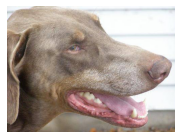

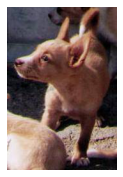

In [462]:
show_images(comp_df,4)

# Create Custom Dataset class and transformers

In [463]:
class img_dataset(Dataset):
    def __init__(self,dataframe,transform=None,test=False):
        self.dataframe = dataframe
        self.transform = transform
        self.test = test
        
    def __getitem__(self,index):
        x = Image.open(self.dataframe.iloc[index,0])
        if self.transform:
            x = self.transform(x)
        if self.test:
            return x
        else:
            y = self.dataframe.iloc[index,1]
            return x,y
        
    def __len__(self):
        return self.dataframe.shape[0]

In [464]:
# Creat transfomers
train_transformer = transforms.Compose([transforms.RandomResizedCrop(224),
                                        transforms.RandomRotation(15),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transformer = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Main Training function

In [465]:
# Print the result of 1 epoch
def print_epoch_result(train_loss,train_acc,val_loss,val_acc):
    print('loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'.format(train_loss,
                                                                              train_acc,
                                                                              val_loss,
                                                                              val_acc))
# Main Training function
def train_model(model, cost_function, optimizer,num_epochs=5):
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    
    # Metrics object
    train_acc_object = metrics.Accuracy(compute_on_step=False)
    val_acc_object = metrics.Accuracy(compute_on_step=False)
    
    for epoch in range(num_epochs):
        """
        On epoch start
        """
        print('-'*15)
        print('Start training {}/{}'.format(epoch+1, num_epochs))
        print('-'*15)
        
        # Training
        train_sub_losses = []
        model.train()
        for x,y in train_loader:
            optimizer.zero_grad()
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            loss.backward()
            optimizer.step()
            #lr_scheduler.step()
            # update loss sublist
            train_sub_losses.append(loss.item())
            # update accuracy object
            train_acc_object(y_hat.cpu(),y.cpu())
            
        # Validation
        val_sub_losses = []
        model.eval()
        for x,y in val_loader:
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            loss = cost_function(y_hat,y)
            val_sub_losses.append(loss.item())
            val_acc_object(y_hat.cpu(),y.cpu())
            
        """
        On epoch end
        """
        # Update the loss list
        train_losses.append(np.mean(train_sub_losses))
        val_losses.append(np.mean(val_sub_losses))
        
        # Update the accuracy list and reset the metrics object 
        train_epoch_acc = train_acc_object.compute()
        val_epoch_acc = val_acc_object.compute()
        train_acc.append(train_epoch_acc)
        val_acc.append(val_epoch_acc)
        train_acc_object.reset()
        val_acc_object.reset()
        
        # print the result of epoch
        print_epoch_result(np.mean(train_sub_losses),train_epoch_acc,np.mean(val_sub_losses),val_epoch_acc)
        
    print('Finish Training.')
    return train_losses, train_acc, val_losses, val_acc

Now the main training function is finished, lets preprare the model, dataset, cost function and optimizer.

In [466]:
# Setting up gpu
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [467]:
# Parameters for dataset
training_samples = comp_df.shape[0] # Use small number first to test whether the model is doing well, then change back to full dataset
test_size=0.05
batch_size = 64

# Reduce the number of samples
sample_df = comp_df.sample(training_samples)

# Split the comp_df into training set and validation set
x_train,x_val,_,_ = train_test_split(sample_df,sample_df,test_size=test_size)

# Create dataloaders form datasets
train_set = img_dataset(x_train, transform=train_transformer)
val_set = img_dataset(x_val, transform=val_transformer)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set , batch_size=batch_size, shuffle=True)

# How many images in training set and val set?
print('Training set: {}, Validation set: {}'.format(x_train.shape[0],x_val.shape[0]))

Training set: 9710, Validation set: 512


Create model
- I will use resnet-50 as a base model (with parameters freezed)
- Two dense layers added at the end.

In [468]:
# Use resnet-50 as a base model
class net(torch.nn.Module):
    def __init__(self, base_model, base_out_features, num_classes):
        super(net,self).__init__()
        self.base_model=base_model
        self.linear1 = torch.nn.Linear(base_out_features, 512)
        self.output = torch.nn.Linear(512,num_classes)
    def forward(self,x):
        x = F.relu(self.base_model(x))
        x = F.relu(self.linear1(x))
        x = self.output(x)
        return x

res = torchvision.models.resnet50(pretrained=True)
for param in res.parameters():
    param.requires_grad=False

model_final = net(base_model=res, base_out_features=res.fc.out_features, num_classes=120)
model_final = model_final.to(device)

In [469]:
# Cost function and optimzier
cost_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam([param for param in model_final.parameters() if param.requires_grad], lr=0.0003)

# Learning rate scheduler
#lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.1)

# Epoch 
EPOCHS = 30

In [470]:
# Start Training
train_losses, train_acc, val_losses, val_acc = train_model(model=model_final, 
                                                           cost_function=cost_function, 
                                                           optimizer=optimizer,
                                                           num_epochs=EPOCHS)

---------------
Start training 1/30
---------------
loss: 2.839, acc: 0.387, val_loss: 0.977, val_acc: 0.754
---------------
Start training 2/30
---------------
loss: 1.497, acc: 0.615, val_loss: 0.676, val_acc: 0.795
---------------
Start training 3/30
---------------
loss: 1.301, acc: 0.660, val_loss: 0.650, val_acc: 0.797
---------------
Start training 4/30
---------------
loss: 1.255, acc: 0.669, val_loss: 0.651, val_acc: 0.801
---------------
Start training 5/30
---------------
loss: 1.201, acc: 0.680, val_loss: 0.549, val_acc: 0.828
---------------
Start training 6/30
---------------
loss: 1.172, acc: 0.683, val_loss: 0.584, val_acc: 0.818
---------------
Start training 7/30
---------------
loss: 1.147, acc: 0.691, val_loss: 0.554, val_acc: 0.826
---------------
Start training 8/30
---------------
loss: 1.132, acc: 0.694, val_loss: 0.561, val_acc: 0.828
---------------
Start training 9/30
---------------
loss: 1.094, acc: 0.703, val_loss: 0.553, val_acc: 0.822
---------------
Sta

# Plot the result

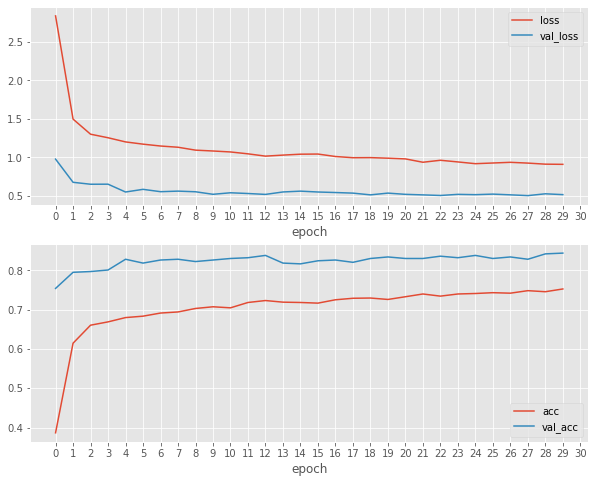

In [476]:
def plot_result(train_loss,val_loss,train_acc,val_acc):
    plt.style.use('ggplot')
    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,8))
    ax1.plot(train_loss,label='loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.legend()
    ax1.set_xlabel('epoch')
    ax1.set_xticks(range(0,EPOCHS+1))
    ax2.plot(train_acc, label='acc')
    ax2.plot(val_acc,label='val_acc')
    ax2.legend()
    ax2.set_xlabel('epoch')
    ax2.set_xticks(range(0,EPOCHS+1))
    plt.show()
plot_result(train_losses,val_losses, train_acc,  val_acc)

- From the graph, it is known that both accuarcy and loss are still improving, training with more epochs (around 40~50) would be better.

# Do prediction on test data

Prepare the test loader first

In [479]:
# Prepare for test data dataframe
#test_df = pd.read_csv('../input/dog-breed-identification/sample_submission.csv')
test_dir = '../input/dog-breed-identification/test'
test_df = test_df[['id']]
test_df.id = test_df.id.apply(lambda x: x+'.jpg')
test_df.id = test_df.id.apply(lambda x : test_dir+'/'+x)
test_set = img_dataset(test_df,transform=val_transformer, test=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Start doing prediction
- Since the submission require us to provide the softmax probabilities, I will use nn.softmax for the outputs.

In [481]:
model_final.eval()
predictions = torch.tensor([])
print('Start predicting....')
for x in test_loader:
    x = x.to(device)
    y_hat = model_final(x)
    predictions = torch.cat([predictions, y_hat.cpu()])
print('Finish prediction.')

Start predicting....
Finish prediction.


Transfer all result to softmax probabilities

In [492]:
predictions = F.softmax(predictions,dim=1).detach().numpy()

# Create CSV file for submission

In [528]:
answer_id = pd.read_csv('../input/dog-breed-identification/sample_submission.csv').id.tolist()
predictions_df = pd.DataFrame(predictions, index=answer_id)
predictions_df.columns = predictions_df.columns.map(index_to_breed)
predictions_df.rename_axis('id', inplace=True)
predictions_df.to_csv('submission.csv')

Thank you very much.